In [20]:
import pandas as pd
import numpy as np
import datetime as dt
import ast 
import matplotlib.pyplot as plt
from scipy.stats import mode

# set cities of interest
cities = [('Atlanta', 'GA'), 
          ('New York', 'NY'), 
          ('New Orleans', 'LA'), 
          ('Seattle', 'WA'), 
          ('Detroit', 'MI')]

# set weeks where weekly data available
weeks = ['03-01', 
         '03-08', 
         '03-15', 
         '03-22', 
         '03-29', 
         '04-05', 
         '04-12', 
         '04-19']

In [21]:
# filter and concatenate weekly data
df = pd.DataFrame()
for week in weeks:
    filepath = './v1/main-file/2020-{}-weekly-patterns.csv.gz'.format(week)
    if week=='04-05':
        filepath = './v1/main-file/2020-04-05-weekly-patterns-corrected.csv.gz'
    weekly_df = pd.read_csv(filepath)
    for city, state in cities:
        subset = weekly_df[(weekly_df.city==city) & (weekly_df.region==state)]
        df = pd.concat([df, subset])
    del weekly_df

# save to pickle
df.to_pickle('./data/weekly_cities_03-01_through_04-19.csv.gz', 
             compression='gzip')

### Checkpoint - load from here for filtered concatenated weekly data

In [52]:
# read from pickle
df = pd.read_pickle('./data/weekly_cities_03-01_through_04-19.csv.gz', 
                    compression='gzip')

In [14]:
def vis_list(x):
    # converts string of format '[1,2,3]' to list of ints
    return np.fromstring(x[1:-1], dtype=int, sep=',')

def filter_cities(dataset):
    # narrow data to the cities of interest
    filtered = pd.DataFrame()
    for city, state in cities:
        subset = dataset[(dataset.city==city) & (dataset.region==state)]
        filtered = pd.concat([filtered, subset])
    return filtered

def days_and_dates(data, time_type):
    
    assert time_type=='seconds' or time_type=='YYYY-MM-DD', \
            'time_type must be \"seconds\" or \"YYYY-MM-DD\" '

    # turn 'visits by day' into list
    data['visits_zip'] = data['visits_by_day'].apply(vis_list)
    
    # create list of all columns except 'visits_zip'
    other_cols = list(data.columns)
    other_cols.remove('visits_zip')

    # Create 1 row for each day
    '''
    Adapted from: 
    https://stackoverflow.com/questions/53860398/
    pandas-dataframe-how-do-i-split-one-row-into-multiple-rows-by-multi-value-colum
    '''
    data = data.set_index(other_cols)['visits_zip'] \
               .apply(pd.Series).stack().reset_index() \
               .rename(columns={0:'visits', 'level_{}' \
                                   .format(len(other_cols)): 'days'})
    
    if time_type=='seconds':
        # For historical data, timestamp in UTC in seconds since January 1, 1970
        data['start_date'] = pd.to_timedelta(data['date_range_start'], 's') \
                                    + pd.to_datetime('1970, 1, 1')
    if time_type=='YYYY-MM-DD':
        # For new weekly data, ISO 8601 format of YYYY-MM-DDTHH:mm:SS±hh:mm 
        # (local time with offset from GMT)
        # The start time will be 12 a.m. Sunday in local time.
        data['start_date'] = pd.to_datetime(data['date_range_start'] \
                                                   .map(lambda x: x[:10]))

    #convert days to time delta
    data['days'] = pd.to_timedelta(data['days'], 'd')

    # compute date
    data['date'] = data['start_date'] + data['days']
    
    return data


In [55]:
# process mar-april 2020 data
df = days_and_dates(df, time_type='YYYY-MM-DD')

In [59]:
# save to pickle
df.to_pickle('./data/daily_cities_03-01-2020_04-25-2020.csv.gz',
                compression='gzip')

In [4]:
# read in feb 2020 data
feb20 = pd.concat([pd.read_csv('./data/Feb20-AllPatterns-PATTERNS-2020_02-2020-03-23/patterns-part1.csv.gz', 
                               compression='gzip'), 
                   pd.read_csv('./data/Feb20-AllPatterns-PATTERNS-2020_02-2020-03-23/patterns-part2.csv.gz', 
                               compression='gzip'), 
                   pd.read_csv('./data/Feb20-AllPatterns-PATTERNS-2020_02-2020-03-23/patterns-part3.csv.gz', 
                               compression='gzip')])

# process feb 2020 data
feb20 = filter_cities(feb20)
feb20 = days_and_dates(feb20, time_type='seconds')

# save to pickle
feb20.to_pickle('./data/daily_cities_02-01-2020_02-29-2020.csv.gz',
                compression='gzip')

In [24]:
# read in jan 2020 data
jan20 = pd.concat([pd.read_csv('./data/Jan20-AllPatterns-PATTERNS-2020_01-2020-03-23/patterns-part1.csv.gz', 
                               compression='gzip'), 
                   pd.read_csv('./data/Jan20-AllPatterns-PATTERNS-2020_01-2020-03-23/patterns-part2.csv.gz', 
                               compression='gzip'), 
                   pd.read_csv('./data/Jan20-AllPatterns-PATTERNS-2020_01-2020-03-23/patterns-part3.csv.gz', 
                               compression='gzip')])

# process jan 2020 data
jan20 = filter_cities(jan20)
jan20 = days_and_dates(jan20, time_type='seconds')

# save to pickle
jan20.to_pickle('./data/daily_cities_01-01-2020_01-31-2020.csv.gz',
                compression='gzip')

In [38]:
# read in historical data for jan 2019
jan19 = pd.concat([pd.read_csv('./data/Jan19-AllRecords-PATTERNS-2019_01-2020-03-26/patterns-part1.csv.gz',
                   compression='gzip'), 
                   pd.read_csv('./data/Jan19-AllRecords-PATTERNS-2019_01-2020-03-26/patterns-part2.csv.gz',
                   compression='gzip'), 
                   pd.read_csv('./data/Jan19-AllRecords-PATTERNS-2019_01-2020-03-26/patterns-part3.csv.gz',
                   compression='gzip')])

# process jan 2019 data
jan19 = filter_cities(jan19)
jan19 = days_and_dates(jan19, time_type='seconds')

# save to pickle
jan19.to_pickle('./data/daily_cities_01-01-2019_01-31-2019.csv.gz',
                compression='gzip')

In [31]:
# read in historical data for feb 2019
feb19 = pd.concat([pd.read_csv('./data/Feb19-AllRecords-PATTERNS-2019_02-2020-03-26/patterns-part1.csv.gz',
                   compression='gzip'), 
                   pd.read_csv('./data/Feb19-AllRecords-PATTERNS-2019_02-2020-03-26/patterns-part2.csv.gz',
                   compression='gzip'), 
                   pd.read_csv('./data/Feb19-AllRecords-PATTERNS-2019_02-2020-03-26/patterns-part3.csv.gz',
                   compression='gzip')])

# process feb 2019 data
feb19 = filter_cities(feb19)
feb19 = days_and_dates(feb19, time_type='seconds')

# save to pickle
feb19.to_pickle('./data/daily_cities_02-01-2019_02-28-2019.csv.gz',
                compression='gzip')

In [35]:
# read in historical data for march 2019
mar19 = pd.concat([pd.read_csv('./data/Mar19-AllPatterns-PATTERNS-2019_03-2020-03-23/patterns-part1.csv.gz',
                   compression='gzip'), 
                   pd.read_csv('./data/Mar19-AllPatterns-PATTERNS-2019_03-2020-03-23/patterns-part2.csv.gz',
                   compression='gzip'), 
                   pd.read_csv('./data/Mar19-AllPatterns-PATTERNS-2019_03-2020-03-23/patterns-part3.csv.gz',
                   compression='gzip')])

# process march 2019 data
mar19 = filter_cities(mar19)
mar19 = days_and_dates(mar19, time_type='seconds')

# save to pickle
mar19.to_pickle('./data/daily_cities_03-01-2019_03-31-2019.csv.gz',
                compression='gzip')

In [61]:
# read in historical data for april 2019
apr19 = pd.concat([pd.read_csv('./data/Apr19-AllPatterns-PATTERNS-2019_04-2020-03-23/patterns-part1.csv.gz',
                   compression='gzip'), 
                   pd.read_csv('./data/Apr19-AllPatterns-PATTERNS-2019_04-2020-03-23/patterns-part2.csv.gz',
                   compression='gzip'), 
                   pd.read_csv('./data/Apr19-AllPatterns-PATTERNS-2019_04-2020-03-23/patterns-part3.csv.gz',
                   compression='gzip')])

# process april 2019 data
apr19 = filter_cities(apr19)
apr19 = days_and_dates(apr19, time_type='seconds')

# save to pickle
apr19.to_pickle('./data/daily_cities_04-01-2019_04-30-2019.csv.gz',
                compression='gzip')

### Checkpoint - load from here for filtered, processed daily data from Jan-April 2019 and 2020 
### [OUTDATED PROCESS]

In [3]:
# read from pickles

jan20 = pd.read_pickle('./data/daily_cities_01-01-2020_01-31-2020.csv.gz',
                       compression='gzip')

feb20 = pd.read_pickle('./data/daily_cities_02-01-2020_02-29-2020.csv.gz',
                       compression='gzip')

marapr20 = pd.read_pickle('./data/daily_cities_03-01-2020_04-25-2020.csv.gz',
                       compression='gzip')

jan19 = pd.read_pickle('./data/daily_cities_01-01-2019_01-31-2019.csv.gz',
                       compression='gzip')

feb19 = pd.read_pickle('./data/daily_cities_02-01-2019_02-28-2019.csv.gz',
                       compression='gzip')

mar19 = pd.read_pickle('./data/daily_cities_03-01-2019_03-31-2019.csv.gz',
                       compression='gzip')

apr19 = pd.read_pickle('./data/daily_cities_04-01-2019_04-30-2019.csv.gz',
                       compression='gzip')

In [4]:
'''
Create Mar-Apr dataset, 19/20 joined on day
OUTDATED
'''

# create one frame for 2019 data
old=pd.concat([mar19, apr19])

# create date column without year
old['date_yearless'] = old['date'].dt.strftime('%m-%d')
df['date_yearless'] = df['date'].dt.strftime('%m-%d')

# join 2019 and 2020 datasets
data = df.join(old.set_index(['date_yearless', 'safegraph_place_id']), 
               on=['date_yearless', 'safegraph_place_id'], how='inner',
               lsuffix='_new', rsuffix='_old', sort=True)

# remove and rename duplicate columns after join
for col in old.columns:
    if (col+'_new' in data.columns) and (col+'_old' in data.columns):
        if all(data[col+'_new']==data[col+'_old']):
            data = data.rename(columns={col+'_new':col}).drop(columns=[col+'_old'])

# rename columns with only one source frame
for col in data.columns:
    if (col in df.columns) and (col not in old.columns):
        data = data.rename(columns={col: col+'_new'})
    if (col not in df.columns) and (col in old.columns):
        data = data.rename(columns={col: col+'_old'})
        
# save to pickle
data.to_pickle('./data/joined_03-01_04-25.csv.gz',
                compression='gzip')

### Checkpoint - load from here for joined Mar-20 2019/2020 dataset, joined on day 
### [OUTDATED]

In [24]:
data = pd.read_pickle('./data/joined_03-01_04-25.csv.gz',
                      compression='gzip')

In [4]:
# view earliest date
# data.date_yearless.min()

In [5]:
# view latest date
# data.date_yearless.max()

In [3]:
# view all columns
# sorted(data.columns)

In [1]:
# #view data overview
# data.head(10)

In [2]:
# view rows where the location name has changed
# data.loc[data['location_name_new']!= \
#          data['location_name_old']][['location_name_new', 'location_name_old']]

### Checkpoint - load from here for filtered, processed daily data from March-April 2019 and 2020

In [13]:
# create mar-april 2019 and 2020 dataframes, from pickles

df20 = pd.read_pickle('./data/daily_cities_03-01-2020_04-25-2020.csv.gz',
                       compression='gzip')

df19 = pd.concat([pd.read_pickle('./data/daily_cities_03-01-2019_03-31-2019.csv.gz',
                       compression='gzip'), 
                  pd.read_pickle('./data/daily_cities_04-01-2019_04-30-2019.csv.gz',
                       compression='gzip')])

In [14]:
# create week of year column, starting sunday, for groupby
df20['week'] = df20['date'].apply(lambda x: (x + dt.timedelta(days=1)).week)
df19['week'] = df19['date'].apply(lambda x: (x + dt.timedelta(days=1)).week)

# create max_hourly_visits (for new data only)
df20['max_hourly_visits'] = df20['visits_by_each_hour']\
                                            .apply(lambda x: max(ast.literal_eval(x)))

#create num_related_same_day_brand
df20['num_related_same_day_brand'] = df20['related_same_day_brand']\
                                            .apply(lambda x: len(ast.literal_eval(x)))
df19['num_related_same_day_brand'] = df19['related_same_day_brand']\
                                            .apply(lambda x: len(ast.literal_eval(x)))

# replace na with string of empty dictionary
# for visit-related dicts with missing values 
df20['visitor_country_of_origin'].fillna('{}', inplace=True)
df19['visitor_country_of_origin'].fillna('{}', inplace=True)
df20['visitor_home_cbgs'].fillna('{}', inplace=True)
df19['visitor_home_cbgs'].fillna('{}', inplace=True)

#create visits_per_visitor_country_of_origin
df20['num_visitor_country_of_origin'] = df20['visitor_country_of_origin']\
                                                .apply(lambda x: len(ast.literal_eval(x)))
df19['num_visitor_country_of_origin'] = df19['visitor_country_of_origin']\
                                              .apply(lambda x: len(ast.literal_eval(x)))

#create visits_per_visitor_home_cbgs
df20['num_visitor_home_cbgs'] = df20['visitor_home_cbgs']\
                                              .apply(lambda x: len(ast.literal_eval(x)))
df19['num_visitor_home_cbgs'] = df19['visitor_home_cbgs']\
                                              .apply(lambda x: len(ast.literal_eval(x)))

In [15]:
agg_dict_20 = {'visits':'sum', # sum the column of interest
               'raw_visit_counts': np.nanmedian,# to check sum is correct
                # take "first" for location-based features (assuming doesnt change)
                'location_name':'first', # to understand records when inspecting manually
                'city': 'first',
                'region':'first',
                'postal_code': 'first',
                'naics_code':'first',
                'brands': 'first',
                # take "median" for numerical visit-based features
                'distance_from_home': np.nanmedian,
                'raw_visitor_counts': np.nanmedian,
                'median_dwell': np.nanmedian,
                'num_visitor_country_of_origin': np.nanmedian,
                'num_visitor_home_cbgs': np.nanmedian,
                'num_related_same_day_brand': np.nanmedian,
                'max_hourly_visits': np.nanmedian,
                'related_same_day_brand':'first' #incase need to use more
                  }

agg_dict_19 = {'visits':'sum', # sum the column of interest
                # take "median" for numerical visit-based features
                'distance_from_home': np.nanmedian,
                'median_dwell': np.nanmedian,
                'num_related_same_day_brand': np.nanmedian,
                'related_same_day_brand':'first' #incase need to use more
                }


In [16]:
#grouby week and location, and aggregate
weekly19 = df19.groupby(['week', 'safegraph_place_id']).agg(agg_dict_19)
weekly20 = df20.groupby(['week', 'safegraph_place_id']).agg(agg_dict_20)

In [17]:
# join 2019 and 2020 
joined = weekly20.join(weekly19, on=['week', 'safegraph_place_id'], how='inner',
                       lsuffix='_2020', rsuffix='_2019', sort=True)

In [293]:
#joined[joined['raw_visit_counts']!=joined['visits_2020']]

There are 20 rows in which raw_visit_counts does not equal the sum of the daily visits. In each of these 20 cases, raw_visit_counts is exactly 1 higher than the sum. We will keep the sum, for consistency.

In [18]:
print(len(joined[joined['visits_2019']==0]))
print(len(joined[joined['visits_2020']==0]))
print(len(joined[joined['raw_visit_counts']==0]))

3109
1
0


Why are there so many more 0 visits in 2019? Has the 2020 data been altered? 

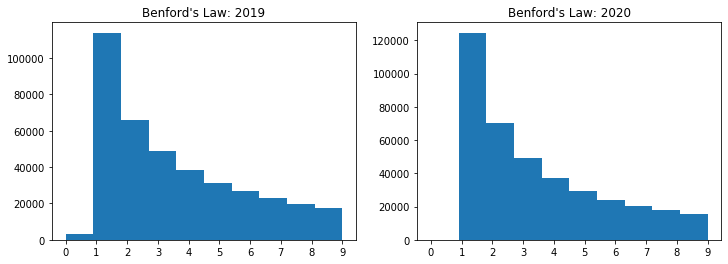

In [21]:
'''
Benford's Law Plots
'''
benford_19 = list(joined['visits_2019'].apply(lambda x: str(x)[0]))
benford_20 = list(joined['visits_2020'].apply(lambda x: str(x)[0]))

fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].hist(sorted(benford_19))
ax[0].set_title('Benford\'s Law: 2019')
ax[1].hist(sorted(benford_20))
ax[1].set_title('Benford\'s Law: 2020')
plt.show()

In [22]:
# Add 1 to all visit counts, to avoid divide-by-zero errors
joined['visits_2019'] = joined['visits_2019'] + 1
joined['visits_2020'] = joined['visits_2020'] + 1

In [23]:
# Calculate % change in visits from 2019 to 2020
joined['change_in_visits'] = (joined['visits_2020'] - joined['visits_2019'])\
                                                /joined['visits_2019']

In [24]:
# Describe our new target variable
joined['change_in_visits'].describe()

count    388440.000000
mean         -0.104214
std           5.837428
min          -0.999824
25%          -0.821053
50%          -0.594771
75%          -0.200000
max        1605.000000
Name: change_in_visits, dtype: float64

In [25]:
#How many places have more than 100x the visits they did in 2019?
len(joined[joined['change_in_visits']>100])

126

In [330]:
# save to pickle
joined.to_pickle('./data/joined_weekly_03-01_04-25.csv.gz', 
             compression='gzip')

### Checkpoint - load from here for joined weekly data, March-April 2019/2020

In [198]:
df = pd.read_pickle('./data/joined_weekly_03-01_04-25.csv.gz', 
             compression='gzip')

In [199]:
df.reset_index(drop=False, inplace=True)

In [200]:
# Create 1-week lag columns
lag_cols = ['visits_2020', 'distance_from_home_2020', 'raw_visitor_counts', 
            'median_dwell_2020', 'num_visitor_country_of_origin',
            'num_visitor_home_cbgs', 'num_related_same_day_brand_2020',
            'max_hourly_visits', 'related_same_day_brand_2020', 'visits_2019',
            'distance_from_home_2019', 'median_dwell_2019',
            'num_related_same_day_brand_2019', 'related_same_day_brand_2019',
            'change_in_visits']

for col in lag_cols:
    df[col+'_lastweek'] = df.groupby('safegraph_place_id')[col].shift(1)

In [201]:
# Create reverse-lag columns for 2019 features
nextweek_cols = ['visits_2019', 'distance_from_home_2019', 'median_dwell_2019',
                   'num_related_same_day_brand_2019', 'related_same_day_brand_2019']

for col in nextweek_cols:
    df[col+'_nextweek'] = df.groupby('safegraph_place_id')[col].shift(-1)

In [202]:
# Create target column (next week's change in visits)
df['target'] = df.groupby('safegraph_place_id')['change_in_visits'].shift(-1)

In [236]:
# df[df.safegraph_place_id=='sg:00001d1ef23c4747bfefd65b6fd0e514'][['week',
#                                                                   'change_in_visits_lastweek', 
#                                                                   'change_in_visits', 
#                                                                   'target']]

In [336]:
# df[df.safegraph_place_id=='sg:00001d1ef23c4747bfefd65b6fd0e514'][['week',
#                                                                   'visits_2019_lastweek', 
#                                                                   'visits_2019', 
#                                                                   'visits_2019_nextweek', 
#                                                                   'visits_2020_lastweek', 
#                                                                   'visits_2020']]

### Using the lag-columns reduces our dataset from 7 weeks to 6 weeks. Is this worth it? We could test the theory if we have time.

In [205]:
# How many locations are in each week?
df.groupby('week').agg({'safegraph_place_id':'count'})

,safegraph_place_id
week,
10,52230
11,51999
12,50210
13,47816
14,47182
15,46099
16,45828
17,47076


Need to remove IDs not present in all weeks.

In [206]:
# get list of ids in each week
id_lists = df.groupby('week').agg({'safegraph_place_id':list})\
                                    ['safegraph_place_id'].tolist()

In [207]:
# get intersection of all weeks
final_set = set(id_lists[0])
for i in range(1,len(id_lists)):
    final_set = final_set & set(id_lists[i])

In [208]:
# Keep only the IDs that appear in all groups
df = df[df.safegraph_place_id.isin(final_set)]

In [209]:
# New size of DF
len(df)

305416

In [210]:
# Check that this worked
df.groupby('week').agg({'safegraph_place_id':'count'})

,safegraph_place_id
week,
10,38177
11,38177
12,38177
13,38177
14,38177
15,38177
16,38177
17,38177


In [211]:
# Check for missing NAICS codes
print('Number of rows missing NAICS code: ', len(df[df.naics_code.isna()]))
print('Number of distinct locations missing NAICS code: ', 
      len(df[df.naics_code.isna()].groupby('safegraph_place_id')))

Number of rows missing NAICS code:  336
Number of distinct locations missing NAICS code:  42


In [214]:
# create NAICS lookup
naics_lists = df.groupby('safegraph_place_id').agg({'naics_code':list})

# Replace NaN NAICS values
df.loc[df.naics_code.isna(), 'naics_code'] = df.safegraph_place_id.apply(lambda x: \
              str(int(mode(list(naics_lists.loc[x])[0], nan_policy='omit')[0][0]))) 
                                                                        
print('Number of rows with NAICS code as Nan: ', len(df[df.naics_code.isna()]))
print('Number of rows with NAICS code as \'0\': ', len(df[df.naics_code=='0']))
print('Number of distinct locations missing NAICS code: ', 
      len(df[df.naics_code=='0'].groupby('safegraph_place_id')))

Number of rows with NAICS code as Nan:  0
Number of rows with NAICS code as '0':  336
Number of distinct locations missing NAICS code:  42


#### This didn't help at all. We could try to do a second pass with brand? Or use discarded rows?

In [223]:
# create features for NAICS substrings

def naics_parts(code, i):
    if code=='0':
        return np.nan
    code=str(code)
    return code[:i]

for i in range(2,6):
    df['naics_{}'.format(i)] = df['naics_code'].apply(naics_parts, args=(i,))

In [231]:
# save as pickle
df.to_pickle('./data/joined_weekly_03-01_04-25_feat_filt.csv.gz', 
             compression='gzip')

In [248]:
# test U_week vs current method
dfcopy = df20.copy()
dfcopy['U_week'] = dfcopy['date'].dt.strftime('%U')

dfcopy[['week', 'U_week']].head()

,week,U_week
0,10,09
1,10,09
2,10,09
3,10,09
4,10,09


In [246]:
# ensure is always 1 more than current method
all(dfcopy['week']==dfcopy['U_week'].astype(int)+1)

True

In [247]:
# Decrease week by 1 to align with strftime '%U'
df['week'] = df['week']-1

In [251]:
# Drop raw_visit_counts (was only used for quality checking)
df.drop(columns=['raw_visit_counts'], inplace=True)

In [255]:
# create list of columns to drop and to use in joining
to_drop=['location_name', 'city', 'region', 'brands']
joining_columns=['week', 'postal_code']
model_df = df.drop(columns=to_drop+joining_columns)

In [261]:
# view number of remaining na values
for col in model_df.columns:
    if model_df[col].isna().sum()>0:
        if '_lastweek' not in col:
            if '_nextweek' not in col:
                print(col)
                print(model_df[col].isna().sum())
                print('\n')

distance_from_home_2020
80225


distance_from_home_2019
252


target
38177


naics_2
336


naics_3
336


naics_4
336


naics_5
336




In [266]:
# drop 2020 distance because missing too often
to_drop.append('distance_from_home_2020')

In [273]:
# Fill missing 2019 distance with training median
# Assume train/val split of 5 weeks vs 1 week
latest_train_week=15

# create distance missing feature
df['distance_missing']=0
df.loc[df.distance_from_home_2019.isna(), 'distance_missing'] = 1

# Replace NaN with median from training weeks
df.loc[df.distance_from_home_2019.isna(), 'distance_from_home_2019'] = \
        df.loc[df.week<=latest_train_week, 'distance_from_home_2019'].median()

In [279]:
# Fill missing NAICS with 0
for i in range(2,6):
    df['naics_{}'.format(i)].fillna('0', inplace=True)

In [285]:
# drop related same day brand dictionaries
brands = [x for x in df.columns if x.startswith('related_same_day_brand')]
to_drop = to_drop + brands

In [290]:
# drop place ID
to_drop.append('safegraph_place_id')

In [293]:
# view modeling columns
model_df = df.drop(columns=to_drop+joining_columns)
sorted(model_df.columns)

['change_in_visits',
 'change_in_visits_lastweek',
 'distance_from_home_2019',
 'distance_from_home_2019_lastweek',
 'distance_from_home_2019_nextweek',
 'distance_from_home_2020_lastweek',
 'distance_missing',
 'max_hourly_visits',
 'max_hourly_visits_lastweek',
 'median_dwell_2019',
 'median_dwell_2019_lastweek',
 'median_dwell_2019_nextweek',
 'median_dwell_2020',
 'median_dwell_2020_lastweek',
 'naics_2',
 'naics_3',
 'naics_4',
 'naics_5',
 'naics_code',
 'num_related_same_day_brand_2019',
 'num_related_same_day_brand_2019_lastweek',
 'num_related_same_day_brand_2019_nextweek',
 'num_related_same_day_brand_2020',
 'num_related_same_day_brand_2020_lastweek',
 'num_visitor_country_of_origin',
 'num_visitor_country_of_origin_lastweek',
 'num_visitor_home_cbgs',
 'num_visitor_home_cbgs_lastweek',
 'raw_visitor_counts',
 'raw_visitor_counts_lastweek',
 'target',
 'visits_2019',
 'visits_2019_lastweek',
 'visits_2019_nextweek',
 'visits_2020',
 'visits_2020_lastweek']

In [301]:
#removing decimals from naics_code
df['naics_code']=df['naics_code'].astype(int).astype(str)

In [313]:
# remove 1st and last weeks
df = df[(df.week!=df.week.min()) & (df.week!=df.week.max())]

In [327]:
# create non-OHE version to share
share_df = df.drop(columns=to_drop)

In [328]:
# create OHE version to share
naics_ohe = pd.get_dummies(share_df, columns=[x for x in share_df.columns if x.startswith('naics_')])

In [329]:
# drop final dummy from each level (choose to drop 0s)
naics_0s = ['naics_{}_0'.format(x) for x in range(2,6)]
naics_0s.append('naics_code_0')
naics_ohe.drop(columns=naics_0s, inplace=True)

In [330]:
# save to csv
naics_ohe.to_csv('./data/safegraph_ohe.csv.gz', 
                 compression='gzip', index=False)

share_df.to_csv('./data/safegraph.csv.gz', 
                 compression='gzip', index=False)

In [331]:
naics_ohe = pd.read_csv('./data/safegraph_ohe.csv.gz', 
                 compression='gzip')

share_df = pd.read_csv('./data/safegraph.csv.gz', 
                 compression='gzip')


In [335]:
# naics_ohe.head()

In [334]:
# share_df.head()